# Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook is inspired by the official colab tutorial of detectron2.
https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

# Install detectron2

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# --> not working because the the cuda version is not compatible! https://github.com/facebookresearch/detectron2/releases
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

fatal: destination path 'detectron2' already exists and is not an empty directory.


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:08:53_PST_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
#!pip install opencv-python

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: /data1/home/tscl/anaconda3/envs/envclaraRCNN/lib/python3.8/site-packages/matplotlib/mpl-data
CONFIGDIR=/data1/home/tscl/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/data1/home/tscl/.cache/matplotlib
Using fontManager instance from /data1/home/tscl/.cache/matplotlib/fontlist-v330.json


# Train on a custom dataset

## Prepare the dataset

In [4]:
#!pip install roboflow

#from roboflow import Roboflow
#rf = Roboflow(api_key="cx2jF1GuAVvRWlxk9ZNY")
#project = rf.workspace("fhv").project("chess-pieces-3")
#dataset = project.version(2).download("coco")

  Obtaining dependency information for PyYAML>=5.3.1 from https://files.pythonhosted.org/packages/c8/6b/6600ac24725c7388255b2f5add93f91e58a5d7efaf4af244fdbcc11a541b/PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (736 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
Starting new HTTPS connection (1): api.roboflow.com:443
https://api.roboflow.com:443 "POST /?api_key=cx2jF1GuAVvRWlxk9ZNY HTTP/1.1" 200 173
loading Roboflow workspace...
Starting new HTTPS connection (1): api.roboflow.com:443
https://api.roboflow.com:443 "GET /fhv?api_key=cx2jF1GuAVvRWlxk9ZNY HTTP/1.1" 200 10124
loading Roboflow project...
Starting new HTTPS connection (1): api.roboflow.com:443
https://api.robof


Extracting Dataset Version Zip to Chess-Pieces-3-2 in coco:: 100%|██████████████| 17920/17920 [00:02<00:00, 6450.33it/s]


In [4]:
import os

# Specify the directory path you want to check
directory_path = "./Chess-Pieces-3-2/train/_annotations.coco.json"

# Use the os.path.exists() function to check if the directory exists
if os.path.exists(directory_path):
    print(f"The directory '{directory_path}' exists.")
else:
    print(f"The directory '{directory_path}' does not exist.")

The directory './Chess-Pieces-3-2/train/_annotations.coco.json' exists.


In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "./Chess-Pieces-3-2/train/_annotations.coco.json", "./Chess-Pieces-3-2/train")
register_coco_instances("my_dataset_val", {}, "./Chess-Pieces-3-2/valid/_annotations.coco.json", "./Chess-Pieces-3-2/valid")
register_coco_instances("my_dataset_test", {}, "./Chess-Pieces-3-2/test/_annotations.coco.json", "./Chess-Pieces-3-2/test" )

[12/11 12:27:30 d2.data.datasets.coco]: Loading ./Chess-Pieces-3-2/train/_annotations.coco.json takes 1.04 seconds.
WARNING [12/11 12:27:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 12:27:30 d2.data.datasets.coco]: Loaded 16986 images in COCO format from ./Chess-Pieces-3-2/train/_annotations.coco.json
Filename: ./Chess-Pieces-3-2/train/IMG20210318212849_jpg.rf.02a1c3e6c76f3ba08050f4552de9b2bf.jpg
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.


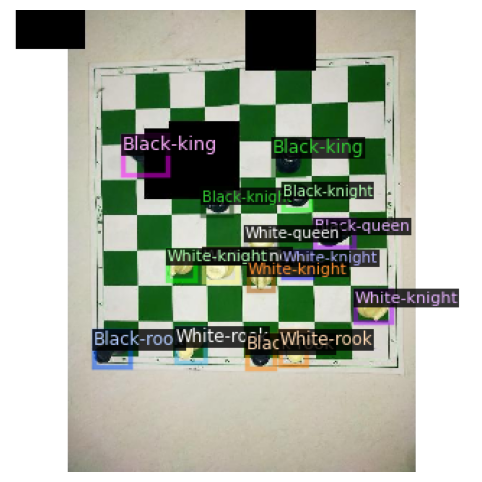

Filename: ./Chess-Pieces-3-2/train/IMG_20220808_140133_jpg.rf.4f8264b900c6a6083144f084fbde1a3a.jpg


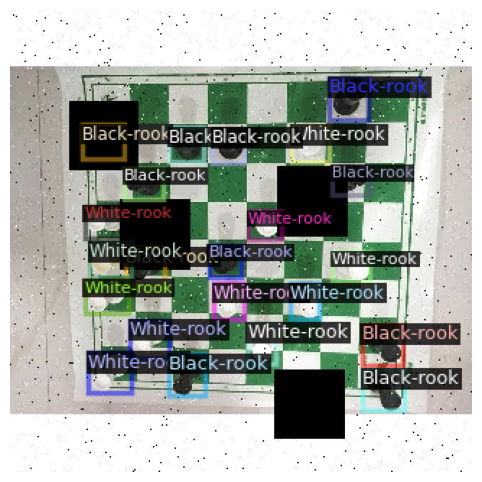

Filename: ./Chess-Pieces-3-2/train/2b1q3_6Qb_r1q3B1_4R2p_3Kb2p_r5k1_1n2q1Rb_N1RQ2q1000656_png_jpg.rf.e195a0e7b5960e8512edfa57a69b2487.jpg


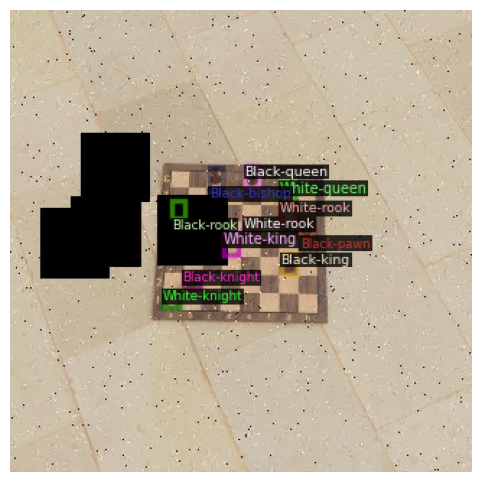

In [6]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import matplotlib

matplotlib.font_manager._log.setLevel(30)  # Suppress font logging

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    print("Filename:", d["file_name"])
    plt.figure(figsize=(8, 6))
    plt.imshow(vis.get_image()) 
    plt.axis('off')
    plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

## Train!
Inspired by this Roboflow Tutorial:
https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW?ref=blog.roboflow.com#scrollTo=TPc8yVBVh52F

In [9]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [13]:
#select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines
#config parameters explained: https://detectron2.readthedocs.io/en/latest/modules/config.html#config-references
#hypterparameter tuning: https://www.researchgate.net/figure/Detectron2-hyperparameter-values_tbl4_363233537
# fix detectron2 error: https://github.com/facebookresearch/detectron2/commit/fc9c33b1f6e5d4c37bbb46dde19af41afc1ddb2a

from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.DEVICE = 'cuda:0'

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATASETS.VALID = ("my_dataset_val",)

# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 4

# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 8  # Increase batch size for faster convergence
cfg.SOLVER.BASE_LR = 0.001  # Learning Rate

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 8000  # Iterations
#cfg.SOLVER.MAX_ITER = 100  # Train for more iterations for better performance
cfg.SOLVER.STEPS = (4000, 6000, 7000)  # Adjust the learning rate schedule
cfg.SOLVER.GAMMA = 0.1  # Reduce LR by a factor of 0.1 at each step

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13 #your number of classes + 1 (superclass)

cfg.TEST.EVAL_PERIOD = 200 # No. of iterations after which the Validation Set is evaluated. 

# Save the configuration to a YAML file
f = open('config.yml','w')
f.write(cfg.dump())
f.close()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/21 17:51:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/21 17:51:08 d2.data.datasets.coco]: Loading ./Chess-Pieces-3-2/train/_annotations.coco.json takes 1.40 seconds.
WARNING [11/21 17:51:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 17:51:08 d2.data.datasets.coco]: Loaded 16986 images in COCO format from ./Chess-Pieces-3-2/train/_annotations.coco.json
[11/21 17:51:09 d2.data.build]: Removed 159 images with no usable annotations. 16827 images left.
[11/21 17:51:09 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-----------:|:-------------|
| Chess-Piece.. | 0            | Black-bishop | 16089        | Black-king  | 12465        |
| Black-knight  | 14508        |  Black-pawn  | 39651        | Black-queen | 10485        |
|  Black-rook   | 15711        | White-bishop | 16041        | White-

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[11/21 17:51:10 d2.engine.train_loop]: Starting training from iteration 0


/data1/home/tscl/anaconda3/envs/envclaraRCNN/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/21 17:51:40 d2.utils.events]:  eta: 3:12:40  iter: 19  total_loss: 4.335  loss_cls: 2.65  loss_box_reg: 0.6984  loss_rpn_cls: 0.8498  loss_rpn_loc: 0.07396    time: 1.4238  last_time: 1.3430  data_time: 0.0242  last_data_time: 0.0159   lr: 1.9981e-05  max_mem: 13156M
[11/21 17:52:09 d2.utils.events]:  eta: 3:12:47  iter: 39  total_loss: 3.306  loss_cls: 2.274  loss_box_reg: 0.7774  loss_rpn_cls: 0.193  loss_rpn_loc: 0.06166    time: 1.4248  last_time: 1.3461  data_time: 0.0149  last_data_time: 0.0154   lr: 3.9961e-05  max_mem: 13156M
[11/21 17:52:37 d2.utils.events]:  eta: 3:12:25  iter: 59  total_loss: 2.615  loss_cls: 1.624  loss_box_reg: 0.7977  loss_rpn_cls: 0.09246  loss_rpn_loc: 0.06268    time: 1.4252  last_time: 1.3552  data_time: 0.0199  last_data_time: 0.0193   lr: 5.9941e-05  max_mem: 13156M
[11/21 17:53:06 d2.utils.events]:  eta: 3:12:33  iter: 79  total_loss: 2.072  loss_cls: 1.065  loss_box_reg: 0.7993  loss_rpn_cls: 0.1437  loss_rpn_loc: 0.06605    time: 1.4361  last

[11/21 17:57:04 d2.utils.events]:  eta: 3:11:54  iter: 239  total_loss: 1.647  loss_cls: 0.7973  loss_box_reg: 0.778  loss_rpn_cls: 0.02655  loss_rpn_loc: 0.04846    time: 1.4600  last_time: 1.3906  data_time: 0.0164  last_data_time: 0.0173   lr: 0.00023976  max_mem: 13156M
[11/21 17:57:33 d2.utils.events]:  eta: 3:11:34  iter: 259  total_loss: 1.643  loss_cls: 0.7915  loss_box_reg: 0.7494  loss_rpn_cls: 0.03835  loss_rpn_loc: 0.05148    time: 1.4613  last_time: 1.5144  data_time: 0.0183  last_data_time: 0.0186   lr: 0.00025974  max_mem: 13156M
[11/21 17:58:03 d2.utils.events]:  eta: 3:11:11  iter: 279  total_loss: 1.578  loss_cls: 0.7739  loss_box_reg: 0.7513  loss_rpn_cls: 0.02531  loss_rpn_loc: 0.04537    time: 1.4633  last_time: 1.5090  data_time: 0.0168  last_data_time: 0.0095   lr: 0.00027972  max_mem: 13156M
[11/21 17:58:33 d2.utils.events]:  eta: 3:10:58  iter: 299  total_loss: 1.601  loss_cls: 0.7635  loss_box_reg: 0.7635  loss_rpn_cls: 0.02313  loss_rpn_loc: 0.04934    time: 

[11/21 18:04:01 d2.utils.events]:  eta: 3:07:24  iter: 519  total_loss: 1.132  loss_cls: 0.6319  loss_box_reg: 0.4301  loss_rpn_cls: 0.02033  loss_rpn_loc: 0.05165    time: 1.4728  last_time: 1.5215  data_time: 0.0198  last_data_time: 0.0191   lr: 0.00051948  max_mem: 13156M
[11/21 18:04:30 d2.utils.events]:  eta: 3:06:55  iter: 539  total_loss: 1.191  loss_cls: 0.6666  loss_box_reg: 0.4571  loss_rpn_cls: 0.02125  loss_rpn_loc: 0.0527    time: 1.4726  last_time: 1.4055  data_time: 0.0180  last_data_time: 0.0273   lr: 0.00053946  max_mem: 13156M
[11/21 18:05:00 d2.utils.events]:  eta: 3:06:37  iter: 559  total_loss: 1.026  loss_cls: 0.5876  loss_box_reg: 0.3855  loss_rpn_cls: 0.01416  loss_rpn_loc: 0.0399    time: 1.4734  last_time: 1.3874  data_time: 0.0185  last_data_time: 0.0108   lr: 0.00055944  max_mem: 13156M
[11/21 18:05:30 d2.utils.events]:  eta: 3:06:11  iter: 579  total_loss: 1.117  loss_cls: 0.6234  loss_box_reg: 0.4197  loss_rpn_cls: 0.01542  loss_rpn_loc: 0.0498    time: 1.

WARNING [11/21 18:10:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 18:10:58 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[11/21 18:10:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/21 18:10:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/21 18:10:58 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[11/21 18:10:58 d2.data.common]: Serialized dataset takes 0.01 MiB
[11/21 18:10:58 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/21 18:10:58 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit argume

WARNING [11/21 18:15:58 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/21 18:15:58 d2.evaluation.evaluator]: Start inference on 16 batches
[11/21 18:15:59 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0006 s/iter. Inference: 0.0774 s/iter. Eval: 0.0003 s/iter. Total: 0.0783 s/iter. ETA=0:00:00
[11/21 18:15:59 d2.evaluation.evaluator]: Total inference time: 0:00:00.903018 (0.082093 s / iter per device, on 1 devices)
[11/21 18:15:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.077364 s / iter per device, on 1 devices)
[11/21 18:15:59 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/21 18:15:59 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[11/21 18:15:59 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.0

[11/21 18:20:59 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

[11/21 18:25:56 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/21 18:25:56 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 16.033 | Black-king  | 31.426 |
| Black-knight      | 37.317 | Black-pawn   | 37.480 | Black-queen | 43.165 |
| Black-rook        | 38.533 | White-bishop | 20.850 | White-king  | 32.673 |
| White-knight      | 47.723 | White-pawn   | 38.291 | White-queen | 32.371 |
| White-rook        | 29.210 |              |        |             |        |
[11/21 18:25:56 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[11/21 18:25:56 d2.evaluation.testing]: copypaste: Task: bbox
[11/21 18:25:56 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 18:25:56 d2.evaluation.testing]: copypaste: 33

[11/21 18:30:55 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 18:30:55 d2.evaluation.testing]: copypaste: 36.4332,55.0829,41.9033,41.1218,39.8912,nan
[11/21 18:30:55 d2.utils.events]:  eta: 2:41:49  iter: 1599  total_loss: 0.8587  loss_cls: 0.4653  loss_box_reg: 0.3435  loss_rpn_cls: 0.007388  loss_rpn_loc: 0.04129    time: 1.4813  last_time: 1.5115  data_time: 0.0177  last_data_time: 0.0092   lr: 0.001  max_mem: 13156M
[11/21 18:31:25 d2.utils.events]:  eta: 2:41:19  iter: 1619  total_loss: 0.7939  loss_cls: 0.419  loss_box_reg: 0.3251  loss_rpn_cls: 0.007008  loss_rpn_loc: 0.03906    time: 1.4816  last_time: 1.5215  data_time: 0.0217  last_data_time: 0.0231   lr: 0.001  max_mem: 13156M
[11/21 18:31:55 d2.utils.events]:  eta: 2:40:48  iter: 1639  total_loss: 0.8471  loss_cls: 0.4287  loss_box_reg: 0.3527  loss_rpn_cls: 0.009877  loss_rpn_loc: 0.04145    time: 1.4815  last_time: 1.3894  data_time: 0.0185  last_data_time: 0.0170   lr: 0.001  max_mem: 13156M
[11/21 1

[11/21 18:37:23 d2.utils.events]:  eta: 2:35:06  iter: 1859  total_loss: 0.8174  loss_cls: 0.4133  loss_box_reg: 0.3328  loss_rpn_cls: 0.009729  loss_rpn_loc: 0.03955    time: 1.4819  last_time: 1.5184  data_time: 0.0180  last_data_time: 0.0187   lr: 0.001  max_mem: 13156M
[11/21 18:37:53 d2.utils.events]:  eta: 2:34:35  iter: 1879  total_loss: 0.7961  loss_cls: 0.4333  loss_box_reg: 0.3269  loss_rpn_cls: 0.009284  loss_rpn_loc: 0.0457    time: 1.4819  last_time: 1.5145  data_time: 0.0183  last_data_time: 0.0173   lr: 0.001  max_mem: 13156M
[11/21 18:38:23 d2.utils.events]:  eta: 2:34:05  iter: 1899  total_loss: 0.718  loss_cls: 0.3729  loss_box_reg: 0.2999  loss_rpn_cls: 0.008637  loss_rpn_loc: 0.03547    time: 1.4820  last_time: 1.5145  data_time: 0.0184  last_data_time: 0.0179   lr: 0.001  max_mem: 13156M
[11/21 18:38:52 d2.utils.events]:  eta: 2:33:33  iter: 1919  total_loss: 0.7458  loss_cls: 0.3823  loss_box_reg: 0.3213  loss_rpn_cls: 0.008969  loss_rpn_loc: 0.03767    time: 1.48

[11/21 18:44:21 d2.utils.events]:  eta: 2:27:59  iter: 2139  total_loss: 0.6999  loss_cls: 0.3605  loss_box_reg: 0.3023  loss_rpn_cls: 0.007444  loss_rpn_loc: 0.03807    time: 1.4822  last_time: 1.5215  data_time: 0.0198  last_data_time: 0.0237   lr: 0.001  max_mem: 13156M
[11/21 18:44:51 d2.utils.events]:  eta: 2:27:29  iter: 2159  total_loss: 0.7799  loss_cls: 0.3829  loss_box_reg: 0.3385  loss_rpn_cls: 0.009364  loss_rpn_loc: 0.0449    time: 1.4823  last_time: 1.5220  data_time: 0.0160  last_data_time: 0.0228   lr: 0.001  max_mem: 13156M
[11/21 18:45:21 d2.utils.events]:  eta: 2:26:59  iter: 2179  total_loss: 0.6827  loss_cls: 0.3144  loss_box_reg: 0.3107  loss_rpn_cls: 0.005359  loss_rpn_loc: 0.04046    time: 1.4824  last_time: 1.5116  data_time: 0.0185  last_data_time: 0.0150   lr: 0.001  max_mem: 13156M
WARNING [11/21 18:45:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 18:45:50 d2.data.datasets.coco]: L

[11/21 18:50:48 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[11/21 18:50:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/21 18:50:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/21 18:50:48 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[11/21 18:50:48 d2.data.common]: Serialized dataset takes 0.01 MiB
[11/21 18:50:48 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/21 18:50:48 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/21 18:50:48 d2.evaluation.evaluator]: Start inference on 16 batches
[11/21 18:50:49 d2.evaluation.evaluator]: Inference d

[11/21 18:55:48 d2.evaluation.evaluator]: Start inference on 16 batches
[11/21 18:55:49 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0007 s/iter. Inference: 0.0772 s/iter. Eval: 0.0002 s/iter. Total: 0.0782 s/iter. ETA=0:00:00
[11/21 18:55:49 d2.evaluation.evaluator]: Total inference time: 0:00:00.900752 (0.081887 s / iter per device, on 1 devices)
[11/21 18:55:49 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.077147 s / iter per device, on 1 devices)
[11/21 18:55:49 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/21 18:55:49 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[11/21 18:55:49 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.06s).
 A

[11/21 19:00:49 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/21 19:00:49 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 27.146 | Black-king  | 51.572 |
| Black-knight      | 50.785 | Black-pawn   | 34.416 | Black-queen | 44.131 |
| Black-rook        | 45.522 | White-bishop | 29.172 | White-king  | 52.827 |
| White-knight      | 62.471 | White-pawn   | 50.740 | White-queen | 66.406 |
| White-rook        | 52.920 |              |        |             |        |
[11/21 19:00:49 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[11/21 19:00:49 d2.evaluation.testing]: copypaste: Task: bbox
[11/21 19:00:49 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 19:00:49 d2.evaluation.testing]: copypaste: 47

[11/21 19:05:45 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 19:05:45 d2.evaluation.testing]: copypaste: 48.1853,71.5198,62.0914,53.1834,53.4020,nan
[11/21 19:05:45 d2.utils.events]:  eta: 2:06:19  iter: 2999  total_loss: 0.7199  loss_cls: 0.3295  loss_box_reg: 0.3254  loss_rpn_cls: 0.005602  loss_rpn_loc: 0.03585    time: 1.4827  last_time: 1.5226  data_time: 0.0229  last_data_time: 0.0235   lr: 0.001  max_mem: 13156M
[11/21 19:06:15 d2.utils.events]:  eta: 2:05:49  iter: 3019  total_loss: 0.6864  loss_cls: 0.3073  loss_box_reg: 0.3117  loss_rpn_cls: 0.00703  loss_rpn_loc: 0.04347    time: 1.4828  last_time: 1.5205  data_time: 0.0225  last_data_time: 0.0210   lr: 0.001  max_mem: 13156M
[11/21 19:06:45 d2.utils.events]:  eta: 2:05:19  iter: 3039  total_loss: 0.662  loss_cls: 0.3102  loss_box_reg: 0.3227  loss_rpn_cls: 0.00628  loss_rpn_loc: 0.03501    time: 1.4828  last_time: 1.5195  data_time: 0.0217  last_data_time: 0.0197   lr: 0.001  max_mem: 13156M
[11/21 19:

[11/21 19:12:13 d2.utils.events]:  eta: 1:59:47  iter: 3259  total_loss: 0.6486  loss_cls: 0.3259  loss_box_reg: 0.2962  loss_rpn_cls: 0.005562  loss_rpn_loc: 0.03577    time: 1.4827  last_time: 1.3968  data_time: 0.0183  last_data_time: 0.0200   lr: 0.001  max_mem: 13156M
[11/21 19:12:43 d2.utils.events]:  eta: 1:59:16  iter: 3279  total_loss: 0.6493  loss_cls: 0.3198  loss_box_reg: 0.3199  loss_rpn_cls: 0.00494  loss_rpn_loc: 0.03238    time: 1.4828  last_time: 1.5161  data_time: 0.0187  last_data_time: 0.0199   lr: 0.001  max_mem: 13156M
[11/21 19:13:12 d2.utils.events]:  eta: 1:58:46  iter: 3299  total_loss: 0.6672  loss_cls: 0.3335  loss_box_reg: 0.3032  loss_rpn_cls: 0.006871  loss_rpn_loc: 0.0333    time: 1.4828  last_time: 1.3988  data_time: 0.0208  last_data_time: 0.0228   lr: 0.001  max_mem: 13156M
[11/21 19:13:42 d2.utils.events]:  eta: 1:58:15  iter: 3319  total_loss: 0.7055  loss_cls: 0.3359  loss_box_reg: 0.3178  loss_rpn_cls: 0.009466  loss_rpn_loc: 0.03533    time: 1.48

[11/21 19:19:09 d2.utils.events]:  eta: 1:52:41  iter: 3539  total_loss: 0.6514  loss_cls: 0.2862  loss_box_reg: 0.3208  loss_rpn_cls: 0.007045  loss_rpn_loc: 0.04255    time: 1.4827  last_time: 1.3026  data_time: 0.0192  last_data_time: 0.0193   lr: 0.001  max_mem: 13156M
[11/21 19:19:39 d2.utils.events]:  eta: 1:52:10  iter: 3559  total_loss: 0.6698  loss_cls: 0.3242  loss_box_reg: 0.3031  loss_rpn_cls: 0.008083  loss_rpn_loc: 0.04357    time: 1.4827  last_time: 1.5239  data_time: 0.0195  last_data_time: 0.0239   lr: 0.001  max_mem: 13156M
[11/21 19:20:09 d2.utils.events]:  eta: 1:51:40  iter: 3579  total_loss: 0.6772  loss_cls: 0.3088  loss_box_reg: 0.3159  loss_rpn_cls: 0.007522  loss_rpn_loc: 0.03727    time: 1.4827  last_time: 1.5314  data_time: 0.0240  last_data_time: 0.0302   lr: 0.001  max_mem: 13156M
WARNING [11/21 19:20:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 19:20:39 d2.data.datasets.coco]: 

[11/21 19:25:37 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[11/21 19:25:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/21 19:25:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/21 19:25:37 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[11/21 19:25:37 d2.data.common]: Serialized dataset takes 0.01 MiB
[11/21 19:25:37 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/21 19:25:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/21 19:25:37 d2.evaluation.evaluator]: Start inference on 16 batches
[11/21 19:25:38 d2.evaluation.evaluator]: Inference d

[11/21 19:30:36 d2.evaluation.evaluator]: Start inference on 16 batches
[11/21 19:30:37 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0007 s/iter. Inference: 0.0772 s/iter. Eval: 0.0002 s/iter. Total: 0.0781 s/iter. ETA=0:00:00
[11/21 19:30:38 d2.evaluation.evaluator]: Total inference time: 0:00:00.901484 (0.081953 s / iter per device, on 1 devices)
[11/21 19:30:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.077155 s / iter per device, on 1 devices)
[11/21 19:30:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/21 19:30:38 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[11/21 19:30:38 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.06s).
 A

[11/21 19:35:38 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/21 19:35:38 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 31.887 | Black-king  | 63.187 |
| Black-knight      | 71.987 | Black-pawn   | 49.126 | Black-queen | 65.157 |
| Black-rook        | 54.659 | White-bishop | 48.988 | White-king  | 67.965 |
| White-knight      | 67.647 | White-pawn   | 48.631 | White-queen | 76.818 |
| White-rook        | 67.001 |              |        |             |        |
[11/21 19:35:38 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[11/21 19:35:38 d2.evaluation.testing]: copypaste: Task: bbox
[11/21 19:35:38 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 19:35:38 d2.evaluation.testing]: copypaste: 59

[11/21 19:40:35 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 19:40:35 d2.evaluation.testing]: copypaste: 60.3902,80.5764,78.6992,61.2641,65.5894,nan
[11/21 19:40:35 d2.utils.events]:  eta: 1:31:00  iter: 4399  total_loss: 0.6348  loss_cls: 0.2866  loss_box_reg: 0.2838  loss_rpn_cls: 0.004983  loss_rpn_loc: 0.03591    time: 1.4831  last_time: 1.5228  data_time: 0.0219  last_data_time: 0.0215   lr: 0.0001  max_mem: 13156M
[11/21 19:41:05 d2.utils.events]:  eta: 1:30:30  iter: 4419  total_loss: 0.5509  loss_cls: 0.2417  loss_box_reg: 0.2696  loss_rpn_cls: 0.006172  loss_rpn_loc: 0.03859    time: 1.4831  last_time: 1.5109  data_time: 0.0158  last_data_time: 0.0109   lr: 0.0001  max_mem: 13156M
[11/21 19:41:34 d2.utils.events]:  eta: 1:29:59  iter: 4439  total_loss: 0.5915  loss_cls: 0.2506  loss_box_reg: 0.2899  loss_rpn_cls: 0.005617  loss_rpn_loc: 0.03283    time: 1.4831  last_time: 1.3879  data_time: 0.0109  last_data_time: 0.0105   lr: 0.0001  max_mem: 13156M
[11/

[11/21 19:47:02 d2.utils.events]:  eta: 1:24:23  iter: 4659  total_loss: 0.5218  loss_cls: 0.2406  loss_box_reg: 0.2576  loss_rpn_cls: 0.00499  loss_rpn_loc: 0.0355    time: 1.4831  last_time: 1.5283  data_time: 0.0136  last_data_time: 0.0248   lr: 0.0001  max_mem: 13156M
[11/21 19:47:31 d2.utils.events]:  eta: 1:23:52  iter: 4679  total_loss: 0.5608  loss_cls: 0.2582  loss_box_reg: 0.275  loss_rpn_cls: 0.005372  loss_rpn_loc: 0.02746    time: 1.4829  last_time: 1.5191  data_time: 0.0130  last_data_time: 0.0227   lr: 0.0001  max_mem: 13156M
[11/21 19:48:01 d2.utils.events]:  eta: 1:23:21  iter: 4699  total_loss: 0.6211  loss_cls: 0.288  loss_box_reg: 0.2837  loss_rpn_cls: 0.008433  loss_rpn_loc: 0.04164    time: 1.4830  last_time: 1.3989  data_time: 0.0130  last_data_time: 0.0237   lr: 0.0001  max_mem: 13156M
[11/21 19:48:31 d2.utils.events]:  eta: 1:22:50  iter: 4719  total_loss: 0.5567  loss_cls: 0.212  loss_box_reg: 0.2878  loss_rpn_cls: 0.005109  loss_rpn_loc: 0.03242    time: 1.48

[11/21 19:53:59 d2.utils.events]:  eta: 1:17:11  iter: 4939  total_loss: 0.6287  loss_cls: 0.273  loss_box_reg: 0.2984  loss_rpn_cls: 0.006192  loss_rpn_loc: 0.04204    time: 1.4830  last_time: 1.3122  data_time: 0.0207  last_data_time: 0.0282   lr: 0.0001  max_mem: 13156M
[11/21 19:54:28 d2.utils.events]:  eta: 1:16:41  iter: 4959  total_loss: 0.5631  loss_cls: 0.2485  loss_box_reg: 0.2772  loss_rpn_cls: 0.004122  loss_rpn_loc: 0.03002    time: 1.4830  last_time: 1.3869  data_time: 0.0197  last_data_time: 0.0099   lr: 0.0001  max_mem: 13156M
[11/21 19:54:58 d2.utils.events]:  eta: 1:16:11  iter: 4979  total_loss: 0.5495  loss_cls: 0.2426  loss_box_reg: 0.274  loss_rpn_cls: 0.003714  loss_rpn_loc: 0.02964    time: 1.4830  last_time: 1.5082  data_time: 0.0181  last_data_time: 0.0107   lr: 0.0001  max_mem: 13156M
Saving checkpoint to ./output/model_0004999.pth
WARNING [11/21 19:55:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping f

WARNING [11/21 20:00:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 20:00:28 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[11/21 20:00:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/21 20:00:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/21 20:00:28 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[11/21 20:00:28 d2.data.common]: Serialized dataset takes 0.01 MiB
[11/21 20:00:28 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/21 20:00:28 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit argume

WARNING [11/21 20:05:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/21 20:05:26 d2.evaluation.evaluator]: Start inference on 16 batches
[11/21 20:05:27 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0007 s/iter. Inference: 0.0773 s/iter. Eval: 0.0002 s/iter. Total: 0.0782 s/iter. ETA=0:00:00
[11/21 20:05:27 d2.evaluation.evaluator]: Total inference time: 0:00:00.900463 (0.081860 s / iter per device, on 1 devices)
[11/21 20:05:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.077223 s / iter per device, on 1 devices)
[11/21 20:05:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/21 20:05:27 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[11/21 20:05:27 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.0

[11/21 20:10:25 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.829
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.621
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

[11/21 20:15:26 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/21 20:15:26 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 34.994 | Black-king  | 65.381 |
| Black-knight      | 68.549 | Black-pawn   | 48.713 | Black-queen | 67.384 |
| Black-rook        | 59.615 | White-bishop | 53.183 | White-king  | 69.890 |
| White-knight      | 67.971 | White-pawn   | 51.948 | White-queen | 78.367 |
| White-rook        | 66.047 |              |        |             |        |
[11/21 20:15:26 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[11/21 20:15:26 d2.evaluation.testing]: copypaste: Task: bbox
[11/21 20:15:26 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 20:15:26 d2.evaluation.testing]: copypaste: 61

[11/21 20:20:25 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 20:20:25 d2.evaluation.testing]: copypaste: 61.4137,83.5526,81.6439,61.0130,66.8329,nan
[11/21 20:20:25 d2.utils.events]:  eta: 0:50:34  iter: 5999  total_loss: 0.565  loss_cls: 0.2324  loss_box_reg: 0.26  loss_rpn_cls: 0.004462  loss_rpn_loc: 0.0308    time: 1.4835  last_time: 1.5244  data_time: 0.0220  last_data_time: 0.0222   lr: 0.0001  max_mem: 13156M
[11/21 20:20:55 d2.utils.events]:  eta: 0:50:03  iter: 6019  total_loss: 0.5313  loss_cls: 0.2282  loss_box_reg: 0.259  loss_rpn_cls: 0.003863  loss_rpn_loc: 0.03068    time: 1.4835  last_time: 1.5132  data_time: 0.0165  last_data_time: 0.0179   lr: 1e-05  max_mem: 13156M
[11/21 20:21:25 d2.utils.events]:  eta: 0:49:33  iter: 6039  total_loss: 0.5748  loss_cls: 0.2563  loss_box_reg: 0.2794  loss_rpn_cls: 0.005598  loss_rpn_loc: 0.0322    time: 1.4835  last_time: 1.1788  data_time: 0.0189  last_data_time: 0.0168   lr: 1e-05  max_mem: 13156M
[11/21 20:21

[11/21 20:26:52 d2.utils.events]:  eta: 0:43:59  iter: 6259  total_loss: 0.5604  loss_cls: 0.2273  loss_box_reg: 0.2645  loss_rpn_cls: 0.008392  loss_rpn_loc: 0.03963    time: 1.4834  last_time: 1.5196  data_time: 0.0211  last_data_time: 0.0265   lr: 1e-05  max_mem: 13156M
[11/21 20:27:22 d2.utils.events]:  eta: 0:43:29  iter: 6279  total_loss: 0.5413  loss_cls: 0.2397  loss_box_reg: 0.2741  loss_rpn_cls: 0.005038  loss_rpn_loc: 0.03235    time: 1.4835  last_time: 1.5224  data_time: 0.0206  last_data_time: 0.0252   lr: 1e-05  max_mem: 13156M
[11/21 20:27:52 d2.utils.events]:  eta: 0:42:58  iter: 6299  total_loss: 0.5636  loss_cls: 0.2423  loss_box_reg: 0.2836  loss_rpn_cls: 0.005213  loss_rpn_loc: 0.03502    time: 1.4835  last_time: 1.5218  data_time: 0.0167  last_data_time: 0.0252   lr: 1e-05  max_mem: 13156M
[11/21 20:28:22 d2.utils.events]:  eta: 0:42:28  iter: 6319  total_loss: 0.5446  loss_cls: 0.2303  loss_box_reg: 0.2711  loss_rpn_cls: 0.004203  loss_rpn_loc: 0.03849    time: 1.

[11/21 20:33:49 d2.utils.events]:  eta: 0:36:55  iter: 6539  total_loss: 0.6125  loss_cls: 0.2671  loss_box_reg: 0.2885  loss_rpn_cls: 0.004842  loss_rpn_loc: 0.03822    time: 1.4833  last_time: 1.5208  data_time: 0.0175  last_data_time: 0.0198   lr: 1e-05  max_mem: 13156M
[11/21 20:34:18 d2.utils.events]:  eta: 0:36:24  iter: 6559  total_loss: 0.5491  loss_cls: 0.234  loss_box_reg: 0.2699  loss_rpn_cls: 0.004335  loss_rpn_loc: 0.02825    time: 1.4833  last_time: 1.5097  data_time: 0.0181  last_data_time: 0.0102   lr: 1e-05  max_mem: 13156M
[11/21 20:34:48 d2.utils.events]:  eta: 0:35:54  iter: 6579  total_loss: 0.55  loss_cls: 0.2498  loss_box_reg: 0.2617  loss_rpn_cls: 0.005081  loss_rpn_loc: 0.03116    time: 1.4834  last_time: 1.5177  data_time: 0.0182  last_data_time: 0.0193   lr: 1e-05  max_mem: 13156M
WARNING [11/21 20:35:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 20:35:18 d2.data.datasets.coco]: Loa

[11/21 20:40:18 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[11/21 20:40:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/21 20:40:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/21 20:40:18 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[11/21 20:40:18 d2.data.common]: Serialized dataset takes 0.01 MiB
[11/21 20:40:18 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/21 20:40:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/21 20:40:18 d2.evaluation.evaluator]: Start inference on 16 batches
[11/21 20:40:19 d2.evaluation.evaluator]: Inference d

[11/21 20:45:16 d2.evaluation.evaluator]: Start inference on 16 batches
[11/21 20:45:18 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0007 s/iter. Inference: 0.0774 s/iter. Eval: 0.0002 s/iter. Total: 0.0783 s/iter. ETA=0:00:00
[11/21 20:45:18 d2.evaluation.evaluator]: Total inference time: 0:00:00.901412 (0.081947 s / iter per device, on 1 devices)
[11/21 20:45:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.077204 s / iter per device, on 1 devices)
[11/21 20:45:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/21 20:45:18 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[11/21 20:45:18 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.06s).
 A

[11/21 20:50:16 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/21 20:50:16 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 36.087 | Black-king  | 67.538 |
| Black-knight      | 67.801 | Black-pawn   | 49.755 | Black-queen | 69.222 |
| Black-rook        | 60.229 | White-bishop | 55.364 | White-king  | 69.973 |
| White-knight      | 67.809 | White-pawn   | 51.750 | White-queen | 78.040 |
| White-rook        | 64.286 |              |        |             |        |
[11/21 20:50:16 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[11/21 20:50:16 d2.evaluation.testing]: copypaste: Task: bbox
[11/21 20:50:16 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 20:50:16 d2.evaluation.testing]: copypaste: 61

[11/21 20:55:15 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/21 20:55:15 d2.evaluation.testing]: copypaste: 61.6749,82.9853,81.1868,62.6546,67.0836,nan
[11/21 20:55:15 d2.utils.events]:  eta: 0:15:10  iter: 7399  total_loss: 0.5714  loss_cls: 0.2366  loss_box_reg: 0.2641  loss_rpn_cls: 0.007231  loss_rpn_loc: 0.03498    time: 1.4836  last_time: 1.5143  data_time: 0.0158  last_data_time: 0.0168   lr: 1e-06  max_mem: 13156M
[11/21 20:55:45 d2.utils.events]:  eta: 0:14:39  iter: 7419  total_loss: 0.6093  loss_cls: 0.2671  loss_box_reg: 0.2828  loss_rpn_cls: 0.006404  loss_rpn_loc: 0.04184    time: 1.4836  last_time: 1.3076  data_time: 0.0199  last_data_time: 0.0248   lr: 1e-06  max_mem: 13156M
[11/21 20:56:14 d2.utils.events]:  eta: 0:14:09  iter: 7439  total_loss: 0.5987  loss_cls: 0.2611  loss_box_reg: 0.2978  loss_rpn_cls: 0.006499  loss_rpn_loc: 0.0363    time: 1.4836  last_time: 1.5203  data_time: 0.0216  last_data_time: 0.0224   lr: 1e-06  max_mem: 13156M
[11/21 2

[11/21 21:01:41 d2.utils.events]:  eta: 0:08:35  iter: 7659  total_loss: 0.5876  loss_cls: 0.2788  loss_box_reg: 0.2828  loss_rpn_cls: 0.005254  loss_rpn_loc: 0.03566    time: 1.4834  last_time: 1.5163  data_time: 0.0173  last_data_time: 0.0197   lr: 1e-06  max_mem: 13156M
[11/21 21:02:10 d2.utils.events]:  eta: 0:08:05  iter: 7679  total_loss: 0.5665  loss_cls: 0.2414  loss_box_reg: 0.2727  loss_rpn_cls: 0.006877  loss_rpn_loc: 0.03648    time: 1.4833  last_time: 1.5160  data_time: 0.0167  last_data_time: 0.0195   lr: 1e-06  max_mem: 13156M
[11/21 21:02:40 d2.utils.events]:  eta: 0:07:34  iter: 7699  total_loss: 0.6154  loss_cls: 0.2954  loss_box_reg: 0.288  loss_rpn_cls: 0.006818  loss_rpn_loc: 0.03932    time: 1.4834  last_time: 1.5165  data_time: 0.0168  last_data_time: 0.0164   lr: 1e-06  max_mem: 13156M
[11/21 21:03:10 d2.utils.events]:  eta: 0:07:04  iter: 7719  total_loss: 0.5141  loss_cls: 0.2306  loss_box_reg: 0.2401  loss_rpn_cls: 0.003868  loss_rpn_loc: 0.02768    time: 1.4

[11/21 21:08:37 d2.utils.events]:  eta: 0:01:30  iter: 7939  total_loss: 0.5425  loss_cls: 0.2507  loss_box_reg: 0.266  loss_rpn_cls: 0.005342  loss_rpn_loc: 0.03602    time: 1.4832  last_time: 1.5214  data_time: 0.0150  last_data_time: 0.0227   lr: 1e-06  max_mem: 13156M
[11/21 21:09:06 d2.utils.events]:  eta: 0:01:00  iter: 7959  total_loss: 0.5153  loss_cls: 0.2301  loss_box_reg: 0.2679  loss_rpn_cls: 0.003711  loss_rpn_loc: 0.02971    time: 1.4832  last_time: 1.5205  data_time: 0.0178  last_data_time: 0.0225   lr: 1e-06  max_mem: 13156M
[11/21 21:09:36 d2.utils.events]:  eta: 0:00:30  iter: 7979  total_loss: 0.5526  loss_cls: 0.235  loss_box_reg: 0.2766  loss_rpn_cls: 0.004141  loss_rpn_loc: 0.03487    time: 1.4832  last_time: 1.5068  data_time: 0.0131  last_data_time: 0.0093   lr: 1e-06  max_mem: 13156M
Saving checkpoint to ./output/model_final.pth
[11/21 21:10:07 d2.utils.events]:  eta: 0:00:00  iter: 7999  total_loss: 0.5232  loss_cls: 0.2204  loss_box_reg: 0.2562  loss_rpn_cls:

# neue config parameters an yolo angelehnt
Das mit der Learning Rate ist einfach Trial and Error!

In [10]:
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.DEVICE = 'cuda:0'

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATASETS.VALID = ("my_dataset_val",)

# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 8

# Number of images per batch across all machines.
# größere batchsize ist nicht möglich gewesen!
cfg.SOLVER.IMS_PER_BATCH = 8 # This is the real "batch size" commonly known to deep learning people # Increase batch size for faster convergence
cfg.SOLVER.BASE_LR = 0.01  # Learning Rate

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 10000  # Iterations
#cfg.SOLVER.MAX_ITER = 100  # Train for more iterations for better performance
cfg.SOLVER.STEPS = (4000, 6000, 7000)  # Adjust the learning rate schedule
cfg.SOLVER.GAMMA = 0.1  # Reduce LR by a factor of 0.1 at each step

#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13 # your number of classes + 1 (superclass)

cfg.TEST.EVAL_PERIOD = 200 # No. of iterations after which the Validation Set is evaluated. 

# Save the configuration to a YAML file
f = open('config.yml','w')
f.write(cfg.dump())
f.close()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/11 12:27:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/11 12:28:00 d2.data.datasets.coco]: Loading ./Chess-Pieces-3-2/train/_annotations.coco.json takes 1.30 seconds.
WARNING [12/11 12:28:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 12:28:00 d2.data.datasets.coco]: Loaded 16986 images in COCO format from ./Chess-Pieces-3-2/train/_annotations.coco.json
[12/11 12:28:01 d2.data.build]: Removed 159 images with no usable annotations. 16827 images left.
[12/11 12:28:01 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-----------:|:-------------|
| Chess-Piece.. | 0            | Black-bishop | 16089        | Black-king  | 12465        |
| Black-knight  | 14508        |  Black-pawn  | 39651        | Black-queen | 10485        |
|  Black-rook   | 15711        | White-bishop | 16041        | White-

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[12/11 12:28:02 d2.engine.train_loop]: Starting training from iteration 0


/data1/home/tscl/anaconda3/envs/envclaraRCNN/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/11 12:28:33 d2.utils.events]:  eta: 3:18:28  iter: 19  total_loss: 3.07  loss_cls: 2.18  loss_box_reg: 0.5179  loss_rpn_cls: 0.3311  loss_rpn_loc: 0.06028    time: 1.4708  last_time: 1.5024  data_time: 0.0255  last_data_time: 0.0084   lr: 0.00019981  max_mem: 13164M
[12/11 12:29:02 d2.utils.events]:  eta: 3:18:53  iter: 39  total_loss: 1.494  loss_cls: 0.7951  loss_box_reg: 0.5423  loss_rpn_cls: 0.08298  loss_rpn_loc: 0.06707    time: 1.4705  last_time: 1.5110  data_time: 0.0102  last_data_time: 0.0087   lr: 0.00039961  max_mem: 13165M
[12/11 12:29:32 d2.utils.events]:  eta: 3:18:51  iter: 59  total_loss: 1.387  loss_cls: 0.6855  loss_box_reg: 0.5911  loss_rpn_cls: 0.04244  loss_rpn_loc: 0.05525    time: 1.4721  last_time: 1.5107  data_time: 0.0096  last_data_time: 0.0092   lr: 0.00059941  max_mem: 13165M
[12/11 12:30:02 d2.utils.events]:  eta: 3:18:28  iter: 79  total_loss: 1.325  loss_cls: 0.645  loss_box_reg: 0.5725  loss_rpn_cls: 0.03384  loss_rpn_loc: 0.04806    time: 1.4757  

[12/11 12:34:05 d2.utils.events]:  eta: 3:16:28  iter: 239  total_loss: 0.8477  loss_cls: 0.4767  loss_box_reg: 0.3219  loss_rpn_cls: 0.0193  loss_rpn_loc: 0.04691    time: 1.4957  last_time: 1.5477  data_time: 0.0095  last_data_time: 0.0098   lr: 0.0023976  max_mem: 13165M
[12/11 12:34:35 d2.utils.events]:  eta: 3:16:16  iter: 259  total_loss: 0.8998  loss_cls: 0.493  loss_box_reg: 0.3309  loss_rpn_cls: 0.01494  loss_rpn_loc: 0.04201    time: 1.4968  last_time: 1.4312  data_time: 0.0099  last_data_time: 0.0159   lr: 0.0025974  max_mem: 13165M
[12/11 12:35:06 d2.utils.events]:  eta: 3:16:15  iter: 279  total_loss: 0.8307  loss_cls: 0.4663  loss_box_reg: 0.3094  loss_rpn_cls: 0.01263  loss_rpn_loc: 0.04363    time: 1.4997  last_time: 1.5469  data_time: 0.0096  last_data_time: 0.0091   lr: 0.0027972  max_mem: 13165M
[12/11 12:35:36 d2.utils.events]:  eta: 3:15:53  iter: 299  total_loss: 0.8707  loss_cls: 0.4746  loss_box_reg: 0.3209  loss_rpn_cls: 0.009466  loss_rpn_loc: 0.0392    time: 

[12/11 12:41:13 d2.utils.events]:  eta: 3:11:53  iter: 519  total_loss: 0.7487  loss_cls: 0.4084  loss_box_reg: 0.2642  loss_rpn_cls: 0.01064  loss_rpn_loc: 0.03974    time: 1.5108  last_time: 1.4345  data_time: 0.0098  last_data_time: 0.0106   lr: 0.0051948  max_mem: 13165M
[12/11 12:41:44 d2.utils.events]:  eta: 3:11:34  iter: 539  total_loss: 0.7007  loss_cls: 0.3946  loss_box_reg: 0.2629  loss_rpn_cls: 0.008437  loss_rpn_loc: 0.0406    time: 1.5110  last_time: 1.5498  data_time: 0.0097  last_data_time: 0.0101   lr: 0.0053946  max_mem: 13165M
[12/11 12:42:14 d2.utils.events]:  eta: 3:11:17  iter: 559  total_loss: 0.8109  loss_cls: 0.4233  loss_box_reg: 0.3013  loss_rpn_cls: 0.01495  loss_rpn_loc: 0.05231    time: 1.5115  last_time: 1.5507  data_time: 0.0096  last_data_time: 0.0103   lr: 0.0055944  max_mem: 13165M
[12/11 12:42:45 d2.utils.events]:  eta: 3:10:56  iter: 579  total_loss: 0.6625  loss_cls: 0.3575  loss_box_reg: 0.2446  loss_rpn_cls: 0.009829  loss_rpn_loc: 0.04625    tim

WARNING [12/11 12:48:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 12:48:22 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[12/11 12:48:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 12:48:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/11 12:48:22 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[12/11 12:48:22 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/11 12:48:22 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/11 12:48:22 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit argume

WARNING [12/11 12:53:29 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/11 12:53:29 d2.evaluation.evaluator]: Start inference on 16 batches
[12/11 12:53:31 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0009 s/iter. Inference: 0.0767 s/iter. Eval: 0.0002 s/iter. Total: 0.0778 s/iter. ETA=0:00:00
[12/11 12:53:31 d2.evaluation.evaluator]: Total inference time: 0:00:00.938436 (0.085312 s / iter per device, on 1 devices)
[12/11 12:53:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.076689 s / iter per device, on 1 devices)
[12/11 12:53:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/11 12:53:31 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[12/11 12:53:31 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.0

[12/11 12:58:38 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

[12/11 13:03:46 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/11 13:03:46 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 27.297 | Black-king  | 42.922 |
| Black-knight      | 70.737 | Black-pawn   | 57.203 | Black-queen | 56.831 |
| Black-rook        | 45.542 | White-bishop | 40.105 | White-king  | 73.954 |
| White-knight      | 69.261 | White-pawn   | 53.347 | White-queen | 75.923 |
| White-rook        | 67.633 |              |        |             |        |
[12/11 13:03:46 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[12/11 13:03:46 d2.evaluation.testing]: copypaste: Task: bbox
[12/11 13:03:46 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 13:03:46 d2.evaluation.testing]: copypaste: 56

[12/11 13:08:52 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 13:08:52 d2.evaluation.testing]: copypaste: 54.6605,77.1668,69.2380,53.5321,66.7047,nan
[12/11 13:08:52 d2.utils.events]:  eta: 2:45:33  iter: 1599  total_loss: 0.682  loss_cls: 0.3207  loss_box_reg: 0.3053  loss_rpn_cls: 0.01121  loss_rpn_loc: 0.05062    time: 1.5198  last_time: 1.4397  data_time: 0.0100  last_data_time: 0.0111   lr: 0.01  max_mem: 13165M
[12/11 13:09:23 d2.utils.events]:  eta: 2:45:02  iter: 1619  total_loss: 0.5241  loss_cls: 0.2385  loss_box_reg: 0.2401  loss_rpn_cls: 0.007938  loss_rpn_loc: 0.04025    time: 1.5198  last_time: 1.4324  data_time: 0.0100  last_data_time: 0.0092   lr: 0.01  max_mem: 13165M
[12/11 13:09:54 d2.utils.events]:  eta: 2:44:31  iter: 1639  total_loss: 0.5223  loss_cls: 0.2383  loss_box_reg: 0.2314  loss_rpn_cls: 0.00974  loss_rpn_loc: 0.03513    time: 1.5200  last_time: 1.4343  data_time: 0.0098  last_data_time: 0.0096   lr: 0.01  max_mem: 13165M
[12/11 13:10:

[12/11 13:15:31 d2.utils.events]:  eta: 2:38:51  iter: 1859  total_loss: 0.6006  loss_cls: 0.2613  loss_box_reg: 0.2591  loss_rpn_cls: 0.007043  loss_rpn_loc: 0.04379    time: 1.5206  last_time: 1.5627  data_time: 0.0098  last_data_time: 0.0096   lr: 0.01  max_mem: 13165M
[12/11 13:16:02 d2.utils.events]:  eta: 2:38:21  iter: 1879  total_loss: 0.5853  loss_cls: 0.2814  loss_box_reg: 0.2803  loss_rpn_cls: 0.007381  loss_rpn_loc: 0.04336    time: 1.5209  last_time: 1.5546  data_time: 0.0097  last_data_time: 0.0101   lr: 0.01  max_mem: 13165M
[12/11 13:16:33 d2.utils.events]:  eta: 2:37:49  iter: 1899  total_loss: 0.4996  loss_cls: 0.2174  loss_box_reg: 0.2435  loss_rpn_cls: 0.004651  loss_rpn_loc: 0.04108    time: 1.5209  last_time: 1.5574  data_time: 0.0095  last_data_time: 0.0092   lr: 0.01  max_mem: 13165M
[12/11 13:17:03 d2.utils.events]:  eta: 2:37:18  iter: 1919  total_loss: 0.5592  loss_cls: 0.2389  loss_box_reg: 0.2633  loss_rpn_cls: 0.005921  loss_rpn_loc: 0.04206    time: 1.520

[12/11 13:22:39 d2.utils.events]:  eta: 2:31:39  iter: 2139  total_loss: 0.4828  loss_cls: 0.2082  loss_box_reg: 0.2268  loss_rpn_cls: 0.006126  loss_rpn_loc: 0.03701    time: 1.5204  last_time: 1.4325  data_time: 0.0095  last_data_time: 0.0106   lr: 0.01  max_mem: 13165M
[12/11 13:23:09 d2.utils.events]:  eta: 2:31:08  iter: 2159  total_loss: 0.5059  loss_cls: 0.2138  loss_box_reg: 0.2537  loss_rpn_cls: 0.00611  loss_rpn_loc: 0.04202    time: 1.5206  last_time: 1.5600  data_time: 0.0096  last_data_time: 0.0105   lr: 0.01  max_mem: 13165M
[12/11 13:23:40 d2.utils.events]:  eta: 2:30:37  iter: 2179  total_loss: 0.5311  loss_cls: 0.2401  loss_box_reg: 0.2427  loss_rpn_cls: 0.007344  loss_rpn_loc: 0.03592    time: 1.5206  last_time: 1.5449  data_time: 0.0096  last_data_time: 0.0101   lr: 0.01  max_mem: 13165M
WARNING [12/11 13:24:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 13:24:10 d2.data.datasets.coco]: Load

[12/11 13:29:16 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[12/11 13:29:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 13:29:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/11 13:29:16 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[12/11 13:29:16 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/11 13:29:16 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/11 13:29:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/11 13:29:16 d2.evaluation.evaluator]: Start inference on 16 batches
[12/11 13:29:18 d2.evaluation.evaluator]: Inference d

[12/11 13:34:25 d2.evaluation.evaluator]: Start inference on 16 batches
[12/11 13:34:27 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0012 s/iter. Inference: 0.0769 s/iter. Eval: 0.0003 s/iter. Total: 0.0784 s/iter. ETA=0:00:00
[12/11 13:34:27 d2.evaluation.evaluator]: Total inference time: 0:00:00.949153 (0.086287 s / iter per device, on 1 devices)
[12/11 13:34:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.076673 s / iter per device, on 1 devices)
[12/11 13:34:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/11 13:34:27 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[12/11 13:34:27 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
 A

[12/11 13:39:33 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/11 13:39:33 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 45.720 | Black-king  | 67.955 |
| Black-knight      | 71.539 | Black-pawn   | 65.734 | Black-queen | 71.357 |
| Black-rook        | 59.176 | White-bishop | 58.909 | White-king  | 76.893 |
| White-knight      | 74.897 | White-pawn   | 59.403 | White-queen | 77.950 |
| White-rook        | 69.366 |              |        |             |        |
[12/11 13:39:33 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[12/11 13:39:33 d2.evaluation.testing]: copypaste: Task: bbox
[12/11 13:39:33 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 13:39:33 d2.evaluation.testing]: copypaste: 66

[12/11 13:44:40 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 13:44:40 d2.evaluation.testing]: copypaste: 59.1046,86.6605,79.7725,59.7633,62.8214,nan
[12/11 13:44:40 d2.utils.events]:  eta: 2:09:24  iter: 2999  total_loss: 0.5402  loss_cls: 0.2291  loss_box_reg: 0.2503  loss_rpn_cls: 0.006229  loss_rpn_loc: 0.03689    time: 1.5213  last_time: 1.5602  data_time: 0.0095  last_data_time: 0.0102   lr: 0.01  max_mem: 13165M
[12/11 13:45:11 d2.utils.events]:  eta: 2:08:53  iter: 3019  total_loss: 0.4837  loss_cls: 0.193  loss_box_reg: 0.232  loss_rpn_cls: 0.005169  loss_rpn_loc: 0.03552    time: 1.5215  last_time: 1.5463  data_time: 0.0098  last_data_time: 0.0095   lr: 0.01  max_mem: 13165M
[12/11 13:45:41 d2.utils.events]:  eta: 2:08:22  iter: 3039  total_loss: 0.4983  loss_cls: 0.2002  loss_box_reg: 0.2345  loss_rpn_cls: 0.005925  loss_rpn_loc: 0.03158    time: 1.5214  last_time: 1.4317  data_time: 0.0099  last_data_time: 0.0098   lr: 0.01  max_mem: 13165M
[12/11 13:46

[12/11 13:51:20 d2.utils.events]:  eta: 2:02:41  iter: 3259  total_loss: 0.4986  loss_cls: 0.206  loss_box_reg: 0.2504  loss_rpn_cls: 0.004427  loss_rpn_loc: 0.03823    time: 1.5220  last_time: 1.5562  data_time: 0.0097  last_data_time: 0.0099   lr: 0.01  max_mem: 13165M
[12/11 13:51:50 d2.utils.events]:  eta: 2:02:10  iter: 3279  total_loss: 0.5294  loss_cls: 0.2307  loss_box_reg: 0.2454  loss_rpn_cls: 0.005013  loss_rpn_loc: 0.03877    time: 1.5221  last_time: 1.5535  data_time: 0.0099  last_data_time: 0.0099   lr: 0.01  max_mem: 13165M
[12/11 13:52:21 d2.utils.events]:  eta: 2:01:39  iter: 3299  total_loss: 0.5298  loss_cls: 0.2086  loss_box_reg: 0.2599  loss_rpn_cls: 0.005557  loss_rpn_loc: 0.04709    time: 1.5221  last_time: 1.4388  data_time: 0.0098  last_data_time: 0.0094   lr: 0.01  max_mem: 13165M
[12/11 13:52:51 d2.utils.events]:  eta: 2:01:08  iter: 3319  total_loss: 0.415  loss_cls: 0.1798  loss_box_reg: 0.2078  loss_rpn_cls: 0.004855  loss_rpn_loc: 0.02703    time: 1.5220 

[12/11 13:58:28 d2.utils.events]:  eta: 1:55:24  iter: 3539  total_loss: 0.5052  loss_cls: 0.2051  loss_box_reg: 0.2556  loss_rpn_cls: 0.006268  loss_rpn_loc: 0.04505    time: 1.5220  last_time: 1.5487  data_time: 0.0099  last_data_time: 0.0095   lr: 0.01  max_mem: 13165M
[12/11 13:58:58 d2.utils.events]:  eta: 1:54:53  iter: 3559  total_loss: 0.4693  loss_cls: 0.1824  loss_box_reg: 0.2316  loss_rpn_cls: 0.003932  loss_rpn_loc: 0.04106    time: 1.5220  last_time: 1.5575  data_time: 0.0100  last_data_time: 0.0100   lr: 0.01  max_mem: 13165M
[12/11 13:59:28 d2.utils.events]:  eta: 1:54:21  iter: 3579  total_loss: 0.4795  loss_cls: 0.2059  loss_box_reg: 0.2347  loss_rpn_cls: 0.007474  loss_rpn_loc: 0.04263    time: 1.5219  last_time: 1.5481  data_time: 0.0096  last_data_time: 0.0091   lr: 0.01  max_mem: 13165M
WARNING [12/11 13:59:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 13:59:59 d2.data.datasets.coco]: Loa

[12/11 14:05:06 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[12/11 14:05:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 14:05:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/11 14:05:06 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[12/11 14:05:06 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/11 14:05:06 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/11 14:05:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/11 14:05:06 d2.evaluation.evaluator]: Start inference on 16 batches
[12/11 14:05:07 d2.evaluation.evaluator]: Inference d

[12/11 14:10:13 d2.evaluation.evaluator]: Start inference on 16 batches
[12/11 14:10:15 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0006 s/iter. Inference: 0.0764 s/iter. Eval: 0.0002 s/iter. Total: 0.0772 s/iter. ETA=0:00:00
[12/11 14:10:15 d2.evaluation.evaluator]: Total inference time: 0:00:00.937005 (0.085182 s / iter per device, on 1 devices)
[12/11 14:10:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.076417 s / iter per device, on 1 devices)
[12/11 14:10:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/11 14:10:15 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[12/11 14:10:15 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
 A

[12/11 14:15:21 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/11 14:15:21 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 48.766 | Black-king  | 67.465 |
| Black-knight      | 72.703 | Black-pawn   | 68.567 | Black-queen | 70.643 |
| Black-rook        | 66.908 | White-bishop | 66.180 | White-king  | 66.511 |
| White-knight      | 64.951 | White-pawn   | 54.668 | White-queen | 79.257 |
| White-rook        | 65.514 |              |        |             |        |
[12/11 14:15:21 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[12/11 14:15:21 d2.evaluation.testing]: copypaste: Task: bbox
[12/11 14:15:21 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 14:15:21 d2.evaluation.testing]: copypaste: 66

[12/11 14:20:29 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 14:20:29 d2.evaluation.testing]: copypaste: 69.0774,89.8406,88.5343,69.3609,73.0967,nan
[12/11 14:20:29 d2.utils.events]:  eta: 1:33:07  iter: 4399  total_loss: 0.4018  loss_cls: 0.1464  loss_box_reg: 0.2158  loss_rpn_cls: 0.002799  loss_rpn_loc: 0.03306    time: 1.5223  last_time: 1.5599  data_time: 0.0104  last_data_time: 0.0115   lr: 0.001  max_mem: 13165M
[12/11 14:20:59 d2.utils.events]:  eta: 1:32:37  iter: 4419  total_loss: 0.3984  loss_cls: 0.1602  loss_box_reg: 0.2147  loss_rpn_cls: 0.004832  loss_rpn_loc: 0.0333    time: 1.5223  last_time: 1.5576  data_time: 0.0099  last_data_time: 0.0097   lr: 0.001  max_mem: 13165M
[12/11 14:21:30 d2.utils.events]:  eta: 1:32:06  iter: 4439  total_loss: 0.3966  loss_cls: 0.1498  loss_box_reg: 0.2052  loss_rpn_cls: 0.002048  loss_rpn_loc: 0.03043    time: 1.5223  last_time: 1.5539  data_time: 0.0098  last_data_time: 0.0106   lr: 0.001  max_mem: 13165M
[12/11 1

[12/11 14:27:08 d2.utils.events]:  eta: 1:26:26  iter: 4659  total_loss: 0.3445  loss_cls: 0.1304  loss_box_reg: 0.1984  loss_rpn_cls: 0.002857  loss_rpn_loc: 0.03058    time: 1.5226  last_time: 1.4346  data_time: 0.0102  last_data_time: 0.0090   lr: 0.001  max_mem: 13165M
[12/11 14:27:39 d2.utils.events]:  eta: 1:25:55  iter: 4679  total_loss: 0.3722  loss_cls: 0.1333  loss_box_reg: 0.1952  loss_rpn_cls: 0.002778  loss_rpn_loc: 0.03102    time: 1.5226  last_time: 1.5497  data_time: 0.0098  last_data_time: 0.0093   lr: 0.001  max_mem: 13165M
[12/11 14:28:09 d2.utils.events]:  eta: 1:25:24  iter: 4699  total_loss: 0.3709  loss_cls: 0.1323  loss_box_reg: 0.2015  loss_rpn_cls: 0.002801  loss_rpn_loc: 0.02787    time: 1.5226  last_time: 1.4378  data_time: 0.0106  last_data_time: 0.0120   lr: 0.001  max_mem: 13165M
[12/11 14:28:39 d2.utils.events]:  eta: 1:24:53  iter: 4719  total_loss: 0.3725  loss_cls: 0.1465  loss_box_reg: 0.2021  loss_rpn_cls: 0.003821  loss_rpn_loc: 0.02924    time: 1.

[12/11 14:34:17 d2.utils.events]:  eta: 1:19:14  iter: 4939  total_loss: 0.3953  loss_cls: 0.1564  loss_box_reg: 0.215  loss_rpn_cls: 0.003151  loss_rpn_loc: 0.03403    time: 1.5227  last_time: 1.5492  data_time: 0.0098  last_data_time: 0.0096   lr: 0.001  max_mem: 13165M
[12/11 14:34:48 d2.utils.events]:  eta: 1:18:44  iter: 4959  total_loss: 0.4165  loss_cls: 0.1739  loss_box_reg: 0.2041  loss_rpn_cls: 0.004349  loss_rpn_loc: 0.0305    time: 1.5227  last_time: 1.4388  data_time: 0.0107  last_data_time: 0.0095   lr: 0.001  max_mem: 13165M
[12/11 14:35:19 d2.utils.events]:  eta: 1:18:13  iter: 4979  total_loss: 0.4196  loss_cls: 0.1627  loss_box_reg: 0.2191  loss_rpn_cls: 0.002818  loss_rpn_loc: 0.03326    time: 1.5228  last_time: 1.5493  data_time: 0.0100  last_data_time: 0.0094   lr: 0.001  max_mem: 13165M
Saving checkpoint to ./output/model_0004999.pth
WARNING [12/11 14:35:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

WARNING [12/11 14:40:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 14:40:56 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[12/11 14:40:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 14:40:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/11 14:40:56 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[12/11 14:40:56 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/11 14:40:56 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/11 14:40:56 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit argume

WARNING [12/11 14:46:04 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/11 14:46:04 d2.evaluation.evaluator]: Start inference on 16 batches
[12/11 14:46:05 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0006 s/iter. Inference: 0.0773 s/iter. Eval: 0.0002 s/iter. Total: 0.0780 s/iter. ETA=0:00:00
[12/11 14:46:05 d2.evaluation.evaluator]: Total inference time: 0:00:00.941674 (0.085607 s / iter per device, on 1 devices)
[12/11 14:46:05 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.077034 s / iter per device, on 1 devices)
[12/11 14:46:05 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/11 14:46:05 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[12/11 14:46:05 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.0

[12/11 14:51:11 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.923
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.774
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

[12/11 14:56:18 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/11 14:56:18 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 57.871 | Black-king  | 76.892 |
| Black-knight      | 75.300 | Black-pawn   | 73.455 | Black-queen | 72.162 |
| Black-rook        | 67.445 | White-bishop | 69.650 | White-king  | 71.106 |
| White-knight      | 72.402 | White-pawn   | 61.903 | White-queen | 74.827 |
| White-rook        | 71.262 |              |        |             |        |
[12/11 14:56:18 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[12/11 14:56:18 d2.evaluation.testing]: copypaste: Task: bbox
[12/11 14:56:18 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 14:56:18 d2.evaluation.testing]: copypaste: 70

[12/11 15:01:24 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 15:01:24 d2.evaluation.testing]: copypaste: 72.5637,93.5707,92.1131,72.7410,74.9702,nan
[12/11 15:01:24 d2.utils.events]:  eta: 0:51:47  iter: 5999  total_loss: 0.3493  loss_cls: 0.1267  loss_box_reg: 0.1927  loss_rpn_cls: 0.002426  loss_rpn_loc: 0.02615    time: 1.5225  last_time: 1.5599  data_time: 0.0102  last_data_time: 0.0092   lr: 0.001  max_mem: 13165M
[12/11 15:01:54 d2.utils.events]:  eta: 0:51:16  iter: 6019  total_loss: 0.3709  loss_cls: 0.1402  loss_box_reg: 0.1917  loss_rpn_cls: 0.003491  loss_rpn_loc: 0.02918    time: 1.5225  last_time: 1.4280  data_time: 0.0100  last_data_time: 0.0098   lr: 0.0001  max_mem: 13165M
[12/11 15:02:25 d2.utils.events]:  eta: 0:50:45  iter: 6039  total_loss: 0.3805  loss_cls: 0.1546  loss_box_reg: 0.1923  loss_rpn_cls: 0.00348  loss_rpn_loc: 0.03007    time: 1.5225  last_time: 1.5620  data_time: 0.0105  last_data_time: 0.0112   lr: 0.0001  max_mem: 13165M
[12/11

[12/11 15:08:02 d2.utils.events]:  eta: 0:45:03  iter: 6259  total_loss: 0.3727  loss_cls: 0.1385  loss_box_reg: 0.1868  loss_rpn_cls: 0.003486  loss_rpn_loc: 0.02501    time: 1.5225  last_time: 1.4345  data_time: 0.0099  last_data_time: 0.0103   lr: 0.0001  max_mem: 13165M
[12/11 15:08:32 d2.utils.events]:  eta: 0:44:32  iter: 6279  total_loss: 0.3662  loss_cls: 0.1446  loss_box_reg: 0.1977  loss_rpn_cls: 0.002851  loss_rpn_loc: 0.03274    time: 1.5225  last_time: 1.5601  data_time: 0.0101  last_data_time: 0.0111   lr: 0.0001  max_mem: 13165M
[12/11 15:09:03 d2.utils.events]:  eta: 0:44:01  iter: 6299  total_loss: 0.4103  loss_cls: 0.1495  loss_box_reg: 0.2235  loss_rpn_cls: 0.00424  loss_rpn_loc: 0.03691    time: 1.5225  last_time: 1.5457  data_time: 0.0109  last_data_time: 0.0099   lr: 0.0001  max_mem: 13165M
[12/11 15:09:34 d2.utils.events]:  eta: 0:43:30  iter: 6319  total_loss: 0.3341  loss_cls: 0.131  loss_box_reg: 0.188  loss_rpn_cls: 0.002869  loss_rpn_loc: 0.02306    time: 1.

[12/11 15:15:11 d2.utils.events]:  eta: 0:37:48  iter: 6539  total_loss: 0.3578  loss_cls: 0.1162  loss_box_reg: 0.1925  loss_rpn_cls: 0.004701  loss_rpn_loc: 0.02847    time: 1.5226  last_time: 1.4311  data_time: 0.0100  last_data_time: 0.0097   lr: 0.0001  max_mem: 13165M
[12/11 15:15:41 d2.utils.events]:  eta: 0:37:17  iter: 6559  total_loss: 0.3928  loss_cls: 0.1522  loss_box_reg: 0.2113  loss_rpn_cls: 0.003182  loss_rpn_loc: 0.03393    time: 1.5226  last_time: 1.5519  data_time: 0.0106  last_data_time: 0.0107   lr: 0.0001  max_mem: 13165M
[12/11 15:16:12 d2.utils.events]:  eta: 0:36:46  iter: 6579  total_loss: 0.3544  loss_cls: 0.1157  loss_box_reg: 0.1915  loss_rpn_cls: 0.00395  loss_rpn_loc: 0.03213    time: 1.5226  last_time: 1.5598  data_time: 0.0102  last_data_time: 0.0115   lr: 0.0001  max_mem: 13165M
WARNING [12/11 15:16:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 15:16:43 d2.data.datasets.coco]

[12/11 15:21:48 d2.data.datasets.coco]: Loaded 16 images in COCO format from ./Chess-Pieces-3-2/test/_annotations.coco.json
[12/11 15:21:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 15:21:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/11 15:21:48 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...
[12/11 15:21:48 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/11 15:21:48 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/11 15:21:48 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/11 15:21:48 d2.evaluation.evaluator]: Start inference on 16 batches
[12/11 15:21:50 d2.evaluation.evaluator]: Inference d

[12/11 15:26:56 d2.evaluation.evaluator]: Start inference on 16 batches
[12/11 15:26:58 d2.evaluation.evaluator]: Inference done 11/16. Dataloading: 0.0009 s/iter. Inference: 0.0768 s/iter. Eval: 0.0002 s/iter. Total: 0.0779 s/iter. ETA=0:00:00
[12/11 15:26:58 d2.evaluation.evaluator]: Total inference time: 0:00:00.955195 (0.086836 s / iter per device, on 1 devices)
[12/11 15:26:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.076715 s / iter per device, on 1 devices)
[12/11 15:26:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/11 15:26:58 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[12/11 15:26:58 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
 A

[12/11 15:32:05 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/11 15:32:05 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 60.010 | Black-king  | 76.340 |
| Black-knight      | 76.642 | Black-pawn   | 74.875 | Black-queen | 74.047 |
| Black-rook        | 71.752 | White-bishop | 67.625 | White-king  | 71.289 |
| White-knight      | 72.584 | White-pawn   | 63.190 | White-queen | 77.351 |
| White-rook        | 72.287 |              |        |             |        |
[12/11 15:32:05 d2.engine.defaults]: Evaluation results for my_dataset_test in csv format:
[12/11 15:32:05 d2.evaluation.testing]: copypaste: Task: bbox
[12/11 15:32:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 15:32:05 d2.evaluation.testing]: copypaste: 71

[12/11 15:37:12 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/11 15:37:12 d2.evaluation.testing]: copypaste: 71.0375,92.8749,91.4172,71.4506,73.8581,nan
[12/11 15:37:12 d2.utils.events]:  eta: 0:15:32  iter: 7399  total_loss: 0.3948  loss_cls: 0.151  loss_box_reg: 0.2108  loss_rpn_cls: 0.003607  loss_rpn_loc: 0.03276    time: 1.5227  last_time: 1.5657  data_time: 0.0097  last_data_time: 0.0091   lr: 1e-05  max_mem: 13165M
[12/11 15:37:42 d2.utils.events]:  eta: 0:15:01  iter: 7419  total_loss: 0.3534  loss_cls: 0.1387  loss_box_reg: 0.1863  loss_rpn_cls: 0.003624  loss_rpn_loc: 0.0278    time: 1.5227  last_time: 1.4294  data_time: 0.0096  last_data_time: 0.0091   lr: 1e-05  max_mem: 13165M
[12/11 15:38:13 d2.utils.events]:  eta: 0:14:30  iter: 7439  total_loss: 0.3562  loss_cls: 0.1274  loss_box_reg: 0.1886  loss_rpn_cls: 0.002075  loss_rpn_loc: 0.03227    time: 1.5227  last_time: 1.3324  data_time: 0.0099  last_data_time: 0.0097   lr: 1e-05  max_mem: 13165M
[12/11 15

[12/11 15:43:48 d2.utils.events]:  eta: 0:08:48  iter: 7659  total_loss: 0.3259  loss_cls: 0.1204  loss_box_reg: 0.1796  loss_rpn_cls: 0.002286  loss_rpn_loc: 0.03012    time: 1.5225  last_time: 1.5588  data_time: 0.0100  last_data_time: 0.0115   lr: 1e-05  max_mem: 13165M
[12/11 15:44:19 d2.utils.events]:  eta: 0:08:17  iter: 7679  total_loss: 0.3536  loss_cls: 0.1282  loss_box_reg: 0.1863  loss_rpn_cls: 0.002751  loss_rpn_loc: 0.02513    time: 1.5225  last_time: 1.5526  data_time: 0.0107  last_data_time: 0.0104   lr: 1e-05  max_mem: 13165M
[12/11 15:44:50 d2.utils.events]:  eta: 0:07:46  iter: 7699  total_loss: 0.3885  loss_cls: 0.1508  loss_box_reg: 0.1908  loss_rpn_cls: 0.002835  loss_rpn_loc: 0.02868    time: 1.5226  last_time: 1.5635  data_time: 0.0099  last_data_time: 0.0104   lr: 1e-05  max_mem: 13165M
[12/11 15:45:20 d2.utils.events]:  eta: 0:07:15  iter: 7719  total_loss: 0.3539  loss_cls: 0.1201  loss_box_reg: 0.1971  loss_rpn_cls: 0.003807  loss_rpn_loc: 0.02941    time: 1.

[12/11 15:50:59 d2.utils.events]:  eta: 0:01:33  iter: 7939  total_loss: 0.3708  loss_cls: 0.1306  loss_box_reg: 0.2118  loss_rpn_cls: 0.003447  loss_rpn_loc: 0.02951    time: 1.5228  last_time: 1.5688  data_time: 0.0098  last_data_time: 0.0094   lr: 1e-05  max_mem: 13165M
[12/11 15:51:29 d2.utils.events]:  eta: 0:01:02  iter: 7959  total_loss: 0.3543  loss_cls: 0.1158  loss_box_reg: 0.1925  loss_rpn_cls: 0.003872  loss_rpn_loc: 0.02706    time: 1.5228  last_time: 1.5664  data_time: 0.0102  last_data_time: 0.0104   lr: 1e-05  max_mem: 13165M
[12/11 15:52:00 d2.utils.events]:  eta: 0:00:31  iter: 7979  total_loss: 0.3424  loss_cls: 0.1307  loss_box_reg: 0.1896  loss_rpn_cls: 0.003665  loss_rpn_loc: 0.02732    time: 1.5227  last_time: 1.3262  data_time: 0.0102  last_data_time: 0.0096   lr: 1e-05  max_mem: 13165M
Saving checkpoint to ./output/model_final.pth
[12/11 15:52:31 d2.utils.events]:  eta: 0:00:00  iter: 7999  total_loss: 0.4084  loss_cls: 0.1458  loss_box_reg: 0.214  loss_rpn_cls

In [14]:
!zip -r ./output.zip output

  adding: output/ (stored 0%)
  adding: output/.ipynb_checkpoints/ (stored 0%)
  adding: output/last_checkpoint (stored 0%)
  adding: output/events.out.tfevents.1696974204.srvgpu.3663345.0 (deflated 72%)
  adding: output/metrics.json (deflated 79%)
  adding: output/model_0004999.pth (deflated 7%)
  adding: output/model_final.pth (deflated 7%)
  adding: output/events.out.tfevents.1700585500.srvgpu.370971.0 (deflated 72%)


## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:



In [11]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS= os.path.join(cfg.OUTPUT_DIR, "../output/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/11 16:47:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/../output/model_final.pth ...
[Checkpointer] Loading from ./output/../output/model_final.pth ...


WARNING [12/11 16:47:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 16:47:15 d2.data.datasets.coco]: Loaded 910 images in COCO format from ./Chess-Pieces-3-2/valid/_annotations.coco.json


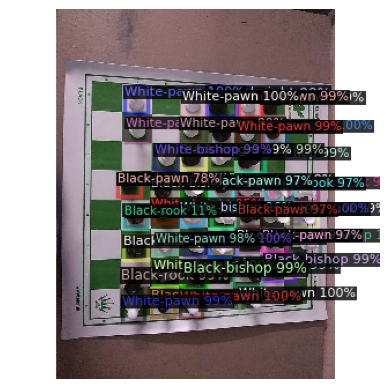

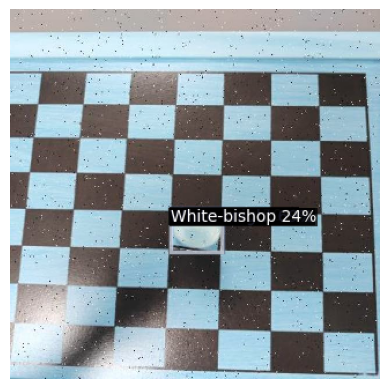

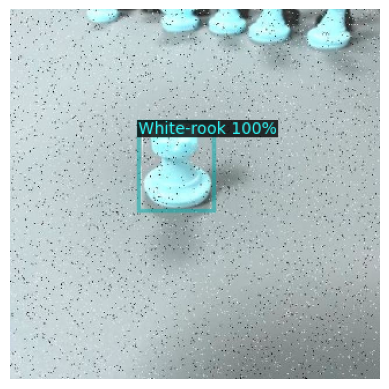

In [12]:
#TODO: why not use the test images for inference?
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("my_dataset_val")
my_dataset_val_metadata = MetadataCatalog.get("my_dataset_val")

for d in random.sample(dataset_dicts, 3):  
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)  
    v = Visualizer(img[:, :, ::-1],
                   metadata=my_dataset_train_metadata,
                   scale=0.5,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure()
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

## Inference on my own images

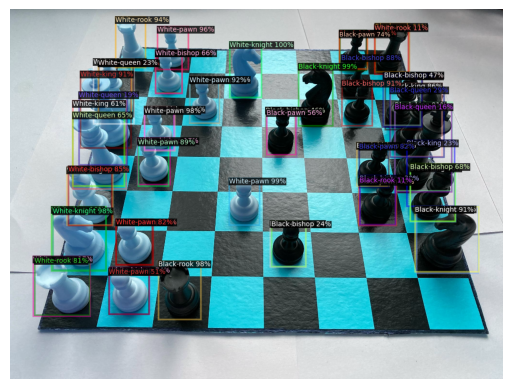

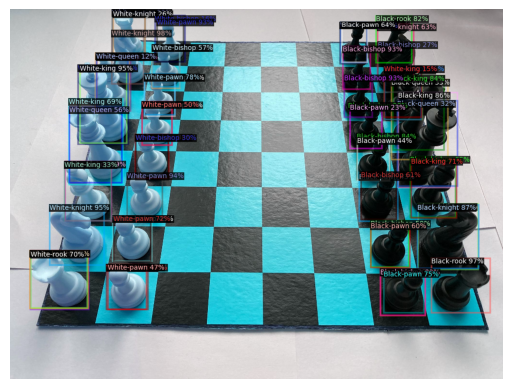

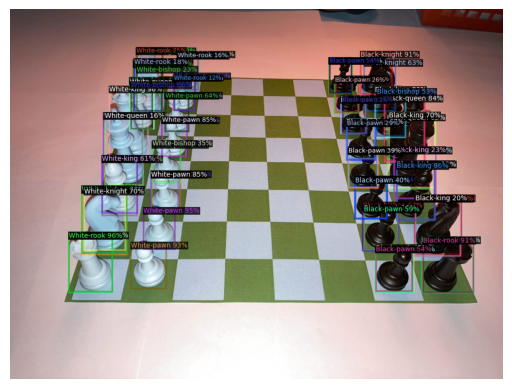

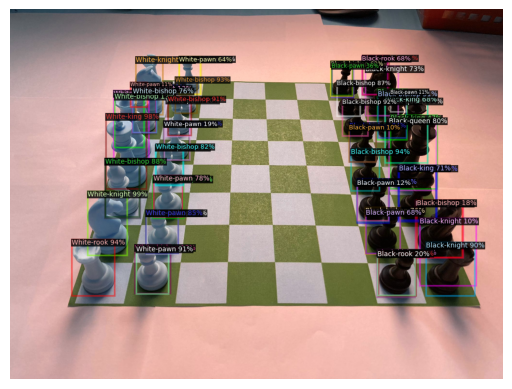

In [17]:
my_dataset_val_metadata = MetadataCatalog.get("my_dataset_val")

image_folder = "./myImages"  # Replace with your folder containing images
image_files = os.listdir(image_folder)

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path)
    outputs = predictor(img)  
    v = Visualizer(img[:, :, ::-1],
                   metadata=my_dataset_train_metadata,
                   scale=0.5,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure()
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# Do the final evaluation of the model's performance on the validation

In [14]:
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.DEVICE = 'cuda:0'

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATASETS.VALID = ("my_dataset_val",)

# Number of data loading threads
#cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.NUM_WORKERS = 8

# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 8  # Increase batch size for faster convergence
#cfg.SOLVER.BASE_LR = 0.001  # Learning Rate
cfg.SOLVER.BASE_LR = 0.01  # Learning Rate

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 8000  # Iterations
#cfg.SOLVER.MAX_ITER = 100  # Train for more iterations for better performance
cfg.SOLVER.STEPS = (4000, 6000, 7000)  # Adjust the learning rate schedule
cfg.SOLVER.GAMMA = 0.1  # Reduce LR by a factor of 0.1 at each step

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13 #your number of classes + 1 (superclass)

cfg.TEST.EVAL_PERIOD = 200 # No. of iterations after which the Validation Set is evaluated. 

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
#evaluator = COCOEvaluator("my_dataset_val", output_dir="./output/evaluation")
evaluator = COCOEvaluator("my_dataset_val")
test_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, test_loader, evaluator))
evaluator.evaluate()

[12/11 16:50:18 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/11 16:50:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 16:50:18 d2.data.datasets.coco]: Loaded 910 images in COCO format from ./Chess-Pieces-3-2/valid/_annotations.coco.json
[12/11 16:50:19 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-----------:|:-------------|
| Chess-Piece.. | 0            | Black-bishop | 1292         | Black-king  | 790          |
| Black-knight  | 987          |  Black-pawn  | 3831         | Black-queen | 786          |
|  Black-rook   | 1171         | White-bishop | 1204         | White-king  | 887          |
| White-knight  | 1125         |  White-pawn  | 2363         | White-queen | 931

[12/11 16:51:36 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category     | AP     | category    | AP     |
|:------------------|:-------|:-------------|:-------|:------------|:-------|
| Chess-Pieces-v3uu | nan    | Black-bishop | 57.444 | Black-king  | 66.498 |
| Black-knight      | 62.115 | Black-pawn   | 57.898 | Black-queen | 67.434 |
| Black-rook        | 59.951 | White-bishop | 57.704 | White-king  | 68.327 |
| White-knight      | 62.018 | White-pawn   | 53.859 | White-queen | 69.000 |
| White-rook        | 60.372 |              |        |             |        |
Loading and preparing results...


TypeError: list indices must be integers or slices, not str